# Nexora Vibe Matcher – Prototype Notebook

**Author:** Vineet Patel        
**Created:** 11-11-2025  

This notebook implements a mini recommendation system per the assignment:
Input vibe query → Embed products → Cosine similarity → Return top-3.

### Why AI at Nexora?
Because Nexora is redefining product discovery through **vibe-based AI recommendations**, and that aligns strongly with my interests in **NLP, embeddings, and personalization systems**. Here, AI isn’t just a backend feature — it becomes the **core user experience**, and I want to contribute to building that impact.       
This prototype shows how embeddings + lightweight vector search can reduce discovery friction, power shoppable influencer content, and evolve into a production pipeline with Pinecone or a managed vector DB for scale.

## 1) Setup & Installs
Run the cell below in Google Colab (or local Jupyter). For Colab, it will install required packages.

In [5]:
# If running in Colab, uncomment to install deps:
# !pip install --quiet openai pandas scikit-learn matplotlib numpy

## 2) Imports & Config
Set your `OPENAI_API_KEY` as an environment variable in Colab (Runtime → Environment variables) or:
```python
import os; os.environ['OPENAI_API_KEY'] = 'your-key-here'
```

**Note:** The assignment mentions `text-embedding-ada-002`. The notebook tries OpenAI's current client first, then falls back to the legacy method. If no API key is found, it uses a **TF‑IDF** local embedding fallback so the notebook still runs end‑to‑end.

In [6]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# IMPORTANT: Never hardcode your API key!
# Set it as an environment variable instead:
# - In Colab: Runtime → Environment Variables
# - In local terminal: set OPENAI_API_KEY=your-key-here (Windows) or export OPENAI_API_KEY=your-key-here (Mac/Linux)
# - Or uncomment the line below (but DON'T commit to GitHub):
# os.environ['OPENAI_API_KEY'] = 'your-key-here'

# Check if API key is available
api_key = os.getenv('OPENAI_API_KEY')
if api_key:
    print("✓ OpenAI API key found")
else:
    print("⚠️  No OpenAI API key found - will use TF-IDF fallback")

✓ OpenAI API key found


## 3) Sample Product Data (10 items)
We keep it small and tagged with simple vibe labels.

In [7]:
products = [
    {"id": 1, "name": "Boho Dress", "desc": "Flowy maxi dress in earthy tones, tassel details — festival and bohemian vibes.", "vibes":["boho","festival","flowy"]},
    {"id": 2, "name": "Urban Bomber Jacket", "desc": "Matte black bomber with patchwork, cropped fit — energetic urban streetwear.", "vibes":["urban","edgy","streetwear"]},
    {"id": 3, "name": "Cozy Knit Sweater", "desc": "Chunky knit, warm neutral colors — perfect for cozy winter evenings.", "vibes":["cozy","casual","winter"]},
    {"id": 4, "name": "Minimal Blazer", "desc": "Tailored minimal blazer, soft grey — clean office and minimalist looks.", "vibes":["minimal","office","smart"]},
    {"id": 5, "name": "Athleisure Hoodie", "desc": "Lightweight hoodie with reflective trims — energetic and sporty city runs.", "vibes":["sporty","energetic","casual"]},
    {"id": 6, "name": "Boho Sandals", "desc": "Leather sandals with braided straps — relaxed boho beach energy.", "vibes":["boho","beach","relaxed"]},
    {"id": 7, "name": "Glam Party Top", "desc": "Sequined crop top with statement shoulders — party-ready glamorous vibes.", "vibes":["glam","party","bold"]},
    {"id": 8, "name": "Vintage Denim Jacket", "desc": "Distressed denim with retro patches and faded wash — vintage casual cool.", "vibes":["vintage","casual","retro"]},
    {"id": 9, "name": "Elegant Midi Skirt", "desc": "Pleated satin midi skirt in champagne — sophisticated and elegant evening wear.", "vibes":["elegant","sophisticated","evening"]},
    {"id": 10, "name": "Graphic Oversized Tee", "desc": "Bold graphic print on oversized cotton tee — laid-back streetwear statement piece.", "vibes":["streetwear","bold","casual"]}
]
df = pd.DataFrame(products)
df

,id,name,desc,vibes
0,1,Boho Dress,"Flowy maxi dress in earthy tones, tassel detai...","[boho, festival, flowy]"
1,2,Urban Bomber Jacket,"Matte black bomber with patchwork, cropped fit...","[urban, edgy, streetwear]"
2,3,Cozy Knit Sweater,"Chunky knit, warm neutral colors — perfect for...","[cozy, casual, winter]"
3,4,Minimal Blazer,"Tailored minimal blazer, soft grey — clean off...","[minimal, office, smart]"
4,5,Athleisure Hoodie,Lightweight hoodie with reflective trims — ene...,"[sporty, energetic, casual]"
5,6,Boho Sandals,Leather sandals with braided straps — relaxed ...,"[boho, beach, relaxed]"
6,7,Glam Party Top,Sequined crop top with statement shoulders — p...,"[glam, party, bold]"
7,8,Vintage Denim Jacket,Distressed denim with retro patches and faded ...,"[vintage, casual, retro]"
8,9,Elegant Midi Skirt,Pleated satin midi skirt in champagne — sophis...,"[elegant, sophisticated, evening]"
9,10,Graphic Oversized Tee,Bold graphic print on oversized cotton tee — l...,"[streetwear, bold, casual]"


## 4) Embedding Helpers (OpenAI + TF‑IDF fallback)
The function attempts to use OpenAI embeddings (`text-embedding-ada-002`) via the current client.
If that fails or no key is set, it returns normalized TF‑IDF vectors so the rest of the flow works.

In [8]:
EMBEDDING_MODEL = "text-embedding-ada-002"
BATCH_SIZE = 8

# Global TF-IDF vectorizer - will be fitted once on products and reused for queries
_tfidf_vectorizer = None

def _get_openai_client():
    """Try to return a modern OpenAI client; fall back to legacy if needed.
    Returns (client, mode) where mode in {"new","legacy"} or (None, None) if not available.
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        return None, None
    try:
        # New-style client
        from openai import OpenAI
        client = OpenAI(api_key=api_key)
        return client, "new"
    except Exception:
        pass
    try:
        # Legacy import path
        import openai
        openai.api_key = api_key
        return openai, "legacy"
    except Exception:
        return None, None

def get_openai_embeddings(texts, model=EMBEDDING_MODEL, batch_size=BATCH_SIZE):
    client, mode = _get_openai_client()
    if client is None:
        return None
    vectors = []
    try:
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            if mode == "new":
                resp = client.embeddings.create(model=model, input=batch)
                for item in resp.data:
                    vectors.append(item.embedding)
            else:  # legacy
                resp = client.Embedding.create(model=model, input=batch)
                for item in resp['data']:
                    vectors.append(item['embedding'])
        return vectors
    except Exception as e:
        print("OpenAI embeddings call failed:", str(e))
        return None

def get_local_tfidf_embeddings(texts, fit=False):
    """Get TF-IDF embeddings. If fit=True, create new vectorizer; else use existing."""
    global _tfidf_vectorizer

    if fit or _tfidf_vectorizer is None:
        _tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1536)
        X = _tfidf_vectorizer.fit_transform(texts).toarray()
    else:
        X = _tfidf_vectorizer.transform(texts).toarray()

    return X.tolist()

def embed_texts(texts, fit=False):
    """Return (np.array vectors, source_tag).
    If fit=True, create new TF-IDF vectorizer (for initial product embedding).
    """
    vecs = get_openai_embeddings(texts)
    if vecs is not None:
        return np.array(vecs), "openai"
    vecs = get_local_tfidf_embeddings(texts, fit=fit)
    return np.array(vecs), "tfidf"

## 5) Embed Product Descriptions
This cell computes and attaches vectors to each product row.

In [9]:
items = df['desc'].tolist()
product_vecs, source = embed_texts(items, fit=True)  # fit=True to train vectorizer on products
print("Embeddings source:", source)
print("Product embeddings shape:", product_vecs.shape)
df['embedding'] = product_vecs.tolist()
df[['id','name','vibes']].head()

OpenAI embeddings call failed: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Embeddings source: tfidf
Product embeddings shape: (10, 187)


,id,name,vibes
0,1,Boho Dress,"[boho, festival, flowy]"
1,2,Urban Bomber Jacket,"[urban, edgy, streetwear]"
2,3,Cozy Knit Sweater,"[cozy, casual, winter]"
3,4,Minimal Blazer,"[minimal, office, smart]"
4,5,Athleisure Hoodie,"[sporty, energetic, casual]"


## 6) Vector Search (Cosine Similarity) + Fallback Handling
Returns top‑k products with similarity scores, and surfaces a fallback prompt if the top score is below a threshold.

In [10]:
def top_k_matches(query, df, k=3, sim_threshold=0.7):
    q_vecs, _ = embed_texts([query], fit=False)  # fit=False to reuse existing vectorizer
    q_vec = q_vecs[0]
    sims = cosine_similarity([q_vec], np.vstack(df['embedding'].values))[0]
    df_scores = df.copy()
    df_scores['score'] = sims
    topk = df_scores.sort_values('score', ascending=False).head(k).reset_index(drop=True)
    top_score = float(topk.loc[0,'score'])
    fallback = None
    if top_score < sim_threshold:
        fallback = {
            "reason":"low_similarity",
            "top_score": top_score,
            "prompt": (
                f"Your vibe query '{query}' returned weak matches (top score {top_score:.3f}). "
                "Consider clarifying the vibe or provide 2–3 keywords, e.g., 'casual cozy', 'urban streetwear'."
            )
        }
    return topk, fallback

# Quick sanity check
q = "energetic urban chic"
topk, fb = top_k_matches(q, df)
print("Top matches:")
print(topk[['name','score']])
print("\nFallback:", fb)

OpenAI embeddings call failed: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Top matches:
                  name     score
0  Urban Bomber Jacket  0.391121
1    Athleisure Hoodie  0.104909
2           Boho Dress  0.000000

Fallback: {'reason': 'low_similarity', 'top_score': 0.391121363472141, 'prompt': "Your vibe query 'energetic urban chic' returned weak matches (top score 0.391). Consider clarifying the vibe or provide 2–3 keywords, e.g., 'casual cozy', 'urban streetwear'."}


## 7) Test & Evaluation (3 queries) + Latency
We run three queries, label results as **good** if top score ≥ 0.7, and plot per‑query latency.

OpenAI embeddings call failed: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
OpenAI embeddings call failed: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
OpenAI embeddings call failed: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code

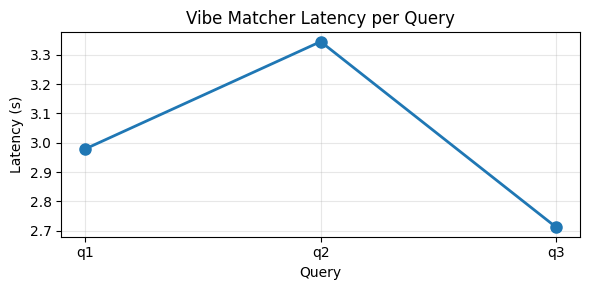

In [11]:
test_queries = [
    "energetic urban chic",
    "cozy festival wear",
    "minimal office wear"
]

results = []
timings = []

for q in test_queries:
    t0 = time.perf_counter()
    topk, fb = top_k_matches(q, df)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    timings.append(elapsed)
    top_list = topk[['name','score']].to_dict(orient='records')
    eval_label = "good" if float(topk.loc[0,'score']) >= 0.7 else ("weak" if float(topk.loc[0,'score']) >= 0.4 else "no-match")
    results.append({
        "query": q,
        "topk": top_list,
        "top_score": float(topk.loc[0,'score']),
        "eval": eval_label,
        "fallback": fb,
        "latency_s": elapsed
    })

# Display results with evaluation metrics
print()
print("="*60)
print("VIBE MATCHER EVALUATION RESULTS")
print("="*60)
for r in results:
    print("\nQuery:", r['query'])
    print("Top-3:", r['topk'])
    print("Top score:", round(r['top_score'],3), "| Eval:", r['eval'], "| Latency(s):", round(r['latency_s'],3))
    if r['fallback']:
        print("⚠️ Fallback ->", r['fallback']['prompt'])
    print("-"*60)

# Summary statistics
good_matches = sum(1 for r in results if r['eval'] == 'good')
print(f"\n📊 Summary: {good_matches}/{len(results)} queries had 'good' matches (score ≥ 0.7)")
print(f"⏱️ Avg latency: {np.mean(timings):.3f}s | Max: {np.max(timings):.3f}s | Min: {np.min(timings):.3f}s")

# Plot latency
plt.figure(figsize=(6,3))
plt.plot(range(1, len(timings)+1), timings, marker='o', linewidth=2, markersize=8)
plt.xticks(range(1, len(timings)+1), [f"q{i}" for i in range(1,len(timings)+1)])
plt.xlabel("Query")
plt.ylabel("Latency (s)")
plt.title("Vibe Matcher Latency per Query")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8) Save Outputs
Export results and the product table (with embeddings) for GitHub submission.

In [12]:
import json
with open("vibe_results.json","w") as f:
    json.dump(results, f, indent=2)
df.to_csv("products_with_embeddings.csv", index=False)
print("Saved: vibe_results.json, products_with_embeddings.csv")

Saved: vibe_results.json, products_with_embeddings.csv


## 9) Reflection & Next Steps
- Integrate a vector database (Pinecone/Weaviate/FAISS) for scalable, persistent nearest-neighbor search, and metadata filtering (e.g., price, size).
- Improve embeddings by using `text-embedding-3-large` or `text-embedding-3-small` (better perf / lower cost tradeoffs) and re-indexing for multilingual support.
- Add richer metadata (color, fabric, season) and product image embeddings (CLIP / vision embeddings) to support combined text+image queries.
- Edge cases handled: ambiguous queries → fallback prompt for clarification; cold-start items handled by tagging manual vibe labels; low-confidence matches flagged for human review.
- Metrics to add next: click-through, conversion uplift from recommended items, and online A/B testing to measure real user preference.

## Acknowledgments

This project was developed with reference to the following resources:

- **OpenAI Documentation**: [OpenAI Embeddings API](https://platform.openai.com/docs/guides/embeddings) - For implementing the `text-embedding-ada-002` model
- **ChatGPT**: Used for code assistance, debugging, and implementation guidance
- **Scikit-learn Documentation**: For TF-IDF vectorization and cosine similarity implementations